## Part II: Predicting Hall of Fame Careers

# Try the model without using cross val predict.  Split into train and test like in part I to get the model right... then figure out cross val predict.

In [262]:
# Connecting to SQLite Database
import pandas as pd
import sqlite3
conn = sqlite3.connect("lahman2016.sqlite")

In [263]:
queryMaster = 'select playerID,nameFirst,nameLast,bats,throws,debut,finalGame from Master;'
queryFielding = 'select * from Fielding;'
queryAwards = 'select playerID,awardID,yearID from AwardsPlayers;'
queryAllStar = 'select playerID, YearID from AllstarFull;'
queryHOF = '''select playerID,yearid,votedBy,needed_note from HallofFame where (votedBy == "BBWAA" or votedBy == "Run Off") 
and inducted == "Y" and category == "Player";'''

In [264]:
batting_df = pd.read_csv('Batting.csv')

In [265]:
master = conn.execute(queryMaster).fetchall()
master_df = pd.DataFrame(master)
fielding = conn.execute(queryFielding).fetchall()
fielding_df = pd.DataFrame(fielding)
awards = conn.execute(queryAwards).fetchall()
awards_df = pd.DataFrame(awards)
allstar = conn.execute(queryAllStar).fetchall()
allstar_df = pd.DataFrame(allstar)
hof = conn.execute(queryHOF).fetchall()
hof_df = pd.DataFrame(hof)

In [266]:
master_cols = ['playerID','nameFirst','nameLast','bats','throws','debut','finalGame']
master_df.columns = master_cols

fielding_cols = ['playerID','yearID','stint','teamID','lgID','Pos','G','GS','InnOuts','PO','A','E','DP','PB','WP','SB','CS','ZR']
fielding_df.columns = fielding_cols

awards_cols = ['playerID','awardID','yearID']
awards_df.columns = awards_cols

allstar_cols = ['playerID','YearID']
allstar_df.columns = allstar_cols

hof_cols = ['playerID','yearid','votedBy','needed_note']
hof_df.columns = hof_cols

In [267]:
print(batting_df.head())

    playerID  yearID  stint teamID lgID   G   AB   R   H  2B  ...    RBI   SB  \
0  abercda01    1871      1    TRO  NaN   1    4   0   0   0  ...    0.0  0.0   
1   addybo01    1871      1    RC1  NaN  25  118  30  32   6  ...   13.0  8.0   
2  allisar01    1871      1    CL1  NaN  29  137  28  40   4  ...   19.0  3.0   
3  allisdo01    1871      1    WS3  NaN  27  133  28  44  10  ...   27.0  1.0   
4  ansonca01    1871      1    RC1  NaN  25  120  29  39  11  ...   16.0  6.0   

    CS  BB   SO  IBB  HBP  SH  SF  GIDP  
0  0.0   0  0.0  NaN  NaN NaN NaN   NaN  
1  1.0   4  0.0  NaN  NaN NaN NaN   NaN  
2  1.0   2  5.0  NaN  NaN NaN NaN   NaN  
3  1.0   0  2.0  NaN  NaN NaN NaN   NaN  
4  2.0   2  1.0  NaN  NaN NaN NaN   NaN  

[5 rows x 22 columns]


In [268]:
player_stats = {}
years_played = {}
for i, row in batting_df.iterrows():
    playerID = row['playerID']
    G = row['G']
    AB = row['AB']
    R = row['R']
    H = row['H']
    twoB = row['2B']
    threeB = row['3B']
    HR = row['HR']
    RBI = row['RBI']
    SB = row['SB']
    CS = row['CS']
    BB = row['BB']
    SO = row['SO']
    IBB = row['IBB']
    HBP = row['HBP']
    SH = row['SH']
    SF = row['SF']
    GIDP = row['GIDP']
    yearID = row['yearID']
    if playerID in player_stats:
        player_stats[playerID]['G'] = player_stats[playerID]['G'] + G
        player_stats[playerID]['AB'] = player_stats[playerID]['AB'] + AB
        player_stats[playerID]['R'] = player_stats[playerID]['R'] + R
        player_stats[playerID]['H'] = player_stats[playerID]['H'] + H
        player_stats[playerID]['2B'] = player_stats[playerID]['2B'] + twoB
        player_stats[playerID]['3B'] = player_stats[playerID]['3B'] + threeB
        player_stats[playerID]['HR'] = player_stats[playerID]['HR'] + HR
        player_stats[playerID]['RBI'] = player_stats[playerID]['RBI'] + RBI
        player_stats[playerID]['SB'] = player_stats[playerID]['SB'] + SB
        player_stats[playerID]['CS'] = player_stats[playerID]['CS'] + CS
        player_stats[playerID]['BB'] = player_stats[playerID]['BB'] + BB
        player_stats[playerID]['SO'] = player_stats[playerID]['SO'] + SO
        player_stats[playerID]['IBB'] = player_stats[playerID]['IBB'] + IBB
        player_stats[playerID]['HBP'] = player_stats[playerID]['HBP'] + HBP
        player_stats[playerID]['SH'] = player_stats[playerID]['SH'] + SH
        player_stats[playerID]['SF'] = player_stats[playerID]['SF'] + SF
        player_stats[playerID]['GIDP'] = player_stats[playerID]['GIDP'] + GIDP
        years_played[playerID].append(yearID)        
    else:
        player_stats[playerID] = {}
        player_stats[playerID]['G'] = G
        player_stats[playerID]['AB'] = AB
        player_stats[playerID]['R'] = R
        player_stats[playerID]['H'] = H
        player_stats[playerID]['2B'] = twoB
        player_stats[playerID]['3B'] = threeB
        player_stats[playerID]['HR'] = HR
        player_stats[playerID]['RBI'] = RBI
        player_stats[playerID]['SB'] = SB
        player_stats[playerID]['CS'] = CS
        player_stats[playerID]['BB'] = BB
        player_stats[playerID]['SO'] = SO
        player_stats[playerID]['IBB'] = IBB
        player_stats[playerID]['HBP'] = HBP
        player_stats[playerID]['SH'] = SH
        player_stats[playerID]['SF'] = SF
        player_stats[playerID]['GIDP'] = GIDP
        years_played[playerID] = []
        years_played[playerID].append(yearID)

In [269]:
eras_played = {}
for k, v in years_played.items():
    eras_played[k] = {}
    player_stats[k]['Years_Played'] = len(list(set(v)))
    for year in v:
        if year < 1920:
            eras_played[k]['pre1920'] = 1
        elif year >= 1920 and year <= 1941:
            eras_played[k]['1920-41'] = 1
        elif year >= 1942 and year <= 1945:
            eras_played[k]['1942-45'] = 1
        elif year >= 1946 and year <= 1962:
            eras_played[k]['1946-62'] = 1
        elif year >= 1963 and year <= 1976:
            eras_played[k]['1963-76'] = 1
        elif year >= 1977 and year <= 1992:
            eras_played[k]['1977-92'] = 1
        elif year >= 1993 and year <= 2009:
            eras_played[k]['1993-2009'] = 1

In [270]:
eras_df = pd.DataFrame.from_dict(eras_played, orient='index')

## Add in years played and eras played in.

In [271]:
fielder_list = []
for i, row in fielding_df.iterrows():
    playerID = row['playerID']
    Gf = row['G']
    GSf = row['GS']
    InnOutsf = row['InnOuts']
    POf = row['PO']
    Af = row['A']
    Ef = row['E']
    DPf = row['DP']
    PBfc = row['PB']
    WPfc = row['WP']
    SBfc = row['SB']
    CSfc = row['CS']
    if playerID in player_stats and playerID in fielder_list:
        player_stats[playerID]['Gf'] = player_stats[playerID]['Gf'] + Gf
        player_stats[playerID]['GSf'] = player_stats[playerID]['GSf'] + GSf
        player_stats[playerID]['InnOutsf'] = player_stats[playerID]['InnOutsf'] + InnOutsf
        player_stats[playerID]['POf'] = player_stats[playerID]['POf'] + POf
        player_stats[playerID]['Af'] = player_stats[playerID]['Af'] + Af
        player_stats[playerID]['Ef'] = player_stats[playerID]['Ef'] + Ef
        player_stats[playerID]['DPf'] = player_stats[playerID]['DPf'] + DPf
        player_stats[playerID]['PBfc'] = player_stats[playerID]['PBfc'] + PBfc
        player_stats[playerID]['WPfc'] = player_stats[playerID]['WPfc'] + WPfc
        player_stats[playerID]['SBfc'] = player_stats[playerID]['SBfc'] + SBfc
        player_stats[playerID]['CSfc'] = player_stats[playerID]['CSfc'] + CSfc
    else:
        fielder_list.append(playerID)
        player_stats[playerID]['Gf'] = Gf
        player_stats[playerID]['GSf'] = GSf
        player_stats[playerID]['InnOutsf'] = InnOutsf
        player_stats[playerID]['POf'] = POf
        player_stats[playerID]['Af'] = Af
        player_stats[playerID]['Ef'] = Ef
        player_stats[playerID]['DPf'] = DPf
        player_stats[playerID]['PBfc'] = PBfc
        player_stats[playerID]['WPfc'] = WPfc
        player_stats[playerID]['SBfc'] = SBfc
        player_stats[playerID]['CSfc'] = CSfc

In [272]:
print(awards_df['awardID'].unique())

['Pitching Triple Crown' 'Triple Crown' 'Baseball Magazine All-Star'
 'Most Valuable Player' 'TSN All-Star' 'TSN Guide MVP'
 'TSN Major League Player of the Year' 'TSN Pitcher of the Year'
 'TSN Player of the Year' 'Rookie of the Year' 'Babe Ruth Award'
 'Lou Gehrig Memorial Award' 'World Series MVP' 'Cy Young Award'
 'Gold Glove' 'TSN Fireman of the Year' 'All-Star Game MVP' 'Hutch Award'
 'Roberto Clemente Award' 'Rolaids Relief Man Award' 'NLCS MVP' 'ALCS MVP'
 'Silver Slugger' 'Branch Rickey Award' 'Hank Aaron Award'
 'TSN Reliever of the Year' 'Comeback Player of the Year'
 'Outstanding DH Award' 'Reliever of the Year Award']


In [273]:
mvp_df = awards_df[awards_df['awardID'] == 'Most Valuable Player']
roy_df = awards_df[awards_df['awardID'] == 'Rookie of the Year']
gg_df = awards_df[awards_df['awardID'] == 'Gold Glove']
ss_df = awards_df[awards_df['awardID'] == 'Silver Slugger']

awards_list = [mvp_df,roy_df,gg_df,ss_df]

In [274]:
print(awards_list[1].head())

       playerID             awardID  yearID
1796  robinja02  Rookie of the Year    1947
1845   darkal01  Rookie of the Year    1948
1899  sievero01  Rookie of the Year    1949
1900  newcodo01  Rookie of the Year    1949
1953  dropowa01  Rookie of the Year    1950


In [275]:
mvp_list = []
roy_list = []
gg_list = []
ss_list = []
lists = [mvp_list,roy_list,gg_list,ss_list]

In [276]:
for index, v in enumerate(awards_list):
    for i, row in v.iterrows():
        playerID = row['playerID']
        award = row['awardID']
        if playerID in player_stats and playerID in lists[index]:
            player_stats[playerID][award] += 1
        else:
            lists[index].append(playerID)
            player_stats[playerID][award] = 1

In [277]:
allstar_list = []
for i, row in allstar_df.iterrows():
    playerID = row['playerID']
    if playerID in player_stats and playerID in allstar_list:
        player_stats[playerID]['AS_games'] += 1
    else:
        allstar_list.append(playerID)
        player_stats[playerID]['AS_games'] = 1

In [278]:
for i, row in hof_df.iterrows():
    playerID = row['playerID']
    if playerID in player_stats:
        player_stats[playerID]['HoF'] = 1

In [279]:
print(len(hof_df))
print(len(master_df))

122
19105


In [280]:
print(dict(list(player_stats.items())[0:2]))

{'kelleha01': {'SO': 14.0, 'Ef': 8.0, 'PBfc': nan, 'SBfc': nan, 'GIDP': nan, 'IBB': nan, 'GSf': nan, 'WPfc': nan, 'SH': 11.0, 'Gf': 146, 'HR': 0, 'POf': 29, '3B': 0, 'AB': 232, 'CS': 0.0, 'RBI': 25.0, 'InnOutsf': nan, 'SB': 0.0, 'R': 16, 'HBP': 1.0, 'BB': 5, 'Af': 114.0, '2B': 9, 'SF': nan, 'G': 147, 'CSfc': nan, 'DPf': 8.0, 'Years_Played': 6, 'H': 50}, 'hermije01': {'SO': 517.0, 'Ef': 27.0, 'PBfc': nan, 'SBfc': nan, 'GIDP': 40.0, 'IBB': 16.0, 'GSf': 520.0, 'WPfc': nan, 'SH': 4.0, 'Gf': 565, 'HR': 65, 'POf': 1068, '3B': 9, 'AB': 2012, 'CS': 8.0, 'RBI': 250.0, 'InnOutsf': 13600.0, 'SB': 22.0, 'R': 248, 'HBP': 21.0, 'BB': 216, 'Af': 20.0, '2B': 104, 'SF': 8.0, 'G': 632, 'CSfc': nan, 'DPf': 2.0, 'Years_Played': 8, 'H': 517}}


In [281]:
stats_df = pd.DataFrame.from_dict(player_stats, orient='index')

In [282]:
stats_df['playerID'] = stats_df.index

In [283]:
print(stats_df.head())

               SO     Ef  PBfc  SBfc   GIDP  IBB     GSf  WPfc    SH      Gf  \
aardsda01     2.0    3.0   NaN   NaN    0.0  0.0     0.0   NaN   1.0   331.0   
aaronha01  1383.0  144.0   NaN   NaN  328.0  NaN  2977.0   NaN  21.0  3020.0   
aaronto01   145.0   22.0   NaN   NaN   36.0  3.0   206.0   NaN   9.0   387.0   
aasedo01      3.0   13.0   NaN   NaN    0.0  0.0    91.0   NaN   0.0   448.0   
abadan01      5.0    1.0   NaN   NaN    1.0  0.0     4.0   NaN   0.0     9.0   

             ...        DPf  Years_Played     H  Most Valuable Player  \
aardsda01    ...        2.0             9     0                   NaN   
aaronha01    ...      218.0            23  3771                   1.0   
aaronto01    ...      124.0             7   216                   NaN   
aasedo01     ...       10.0            13     0                   NaN   
abadan01     ...        3.0             3     2                   NaN   

           AS_games  HoF  Rookie of the Year  Silver Slugger  Gold Glove  \
aard

In [284]:
print(master_df.head())

    playerID nameFirst nameLast bats throws       debut   finalGame
0  aardsda01     David  Aardsma    R      R  2004-04-06  2015-08-23
1  aaronha01      Hank    Aaron    R      R  1954-04-13  1976-10-03
2  aaronto01    Tommie    Aaron    R      R  1962-04-10  1971-09-26
3   aasedo01       Don     Aase    R      R  1977-07-26  1990-10-03
4   abadan01      Andy     Abad    L      L  2001-09-10  2006-04-13


In [285]:
master_df = master_df.join(stats_df,on='playerID',how='inner',rsuffix='mstr')

In [286]:
def bats_throws(col):
    if col == "R":
        return 1
    else:
        return 0
        
master_df['bats_R'] = master_df['bats'].apply(bats_throws)
master_df['throws_R'] = master_df['throws'].apply(bats_throws)

In [287]:
pos_list = []
pos_dict = {}
for i, row in fielding_df.iterrows():
    playerID = row['playerID']
    games = row['G']
    pos = row['Pos']
    if playerID in pos_dict:
        if pos in pos_dict[playerID]:
            pos_dict[playerID][pos] = pos_dict[playerID][pos] + games
        else:
            pos_dict[playerID][pos] = games
    else:
        pos_dict[playerID] = {}
        pos_dict[playerID][pos] = games

In [288]:
primary_pos_dict = {}
player_list = []
for k, v in pos_dict.items():
    playerID = k
    primary_pos_dict[playerID] = {}
    primary_pos_dict[playerID]['game_count'] = 0
    primary_pos_dict[playerID]['game_count2'] = 0
    primary_pos_dict[playerID]['pos'] = ''
    for key, val in v.items():      
        if val > primary_pos_dict[playerID]['game_count']:
            primary_pos_dict[playerID]['pos2'] = primary_pos_dict[playerID]['pos']
            primary_pos_dict[playerID]['pos'] = key
            primary_pos_dict[playerID]['game_count2'] = primary_pos_dict[playerID]['game_count']
            primary_pos_dict[playerID]['game_count'] = val

In [289]:
primary_pos_df = pd.DataFrame.from_dict(primary_pos_dict, orient='index')

In [290]:
primary_pos_df = primary_pos_df.drop(['game_count','game_count2'], axis=1)

In [291]:
primary_pos_df = primary_pos_df[primary_pos_df['pos'] != 'P']

In [292]:
print(primary_pos_df[primary_pos_df['pos2'] == 'P'])

          pos2 pos
coreyfr01    P  3B
yeagejo01    P  3B


In [293]:
master_df = master_df.join(primary_pos_df,on='playerID',how='right')

In [294]:
dummy_df = pd.get_dummies(master_df['pos'], prefix='pos_')
master_df = pd.concat([master_df, dummy_df], axis=1)

In [295]:
print(master_df.columns)

Index(['playerID', 'nameFirst', 'nameLast', 'bats', 'throws', 'debut',
       'finalGame', 'SO', 'Ef', 'PBfc', 'SBfc', 'GIDP', 'IBB', 'GSf', 'WPfc',
       'SH', 'Gf', 'HR', 'POf', '3B', 'AB', 'CS', 'RBI', 'InnOutsf', 'SB', 'R',
       'HBP', 'BB', 'Af', '2B', 'SF', 'G', 'CSfc', 'DPf', 'Years_Played', 'H',
       'Most Valuable Player', 'AS_games', 'HoF', 'Rookie of the Year',
       'Silver Slugger', 'Gold Glove', 'playerIDmstr', 'bats_R', 'throws_R',
       'pos2', 'pos', 'pos__1B', 'pos__2B', 'pos__3B', 'pos__C', 'pos__OF',
       'pos__SS'],
      dtype='object')


In [296]:
# Eliminating unnecessary columns
df = master_df.drop(['nameFirst', 'nameLast', 'CS', 'IBB', 'bats', 'throws','GIDP','GSf','Ef','CSfc', 'POf','Gf', 'Af', 'PBfc', 'WPfc','InnOutsf', 'SBfc','DPf', 'SH', 'SO','playerIDmstr', 'pos'], axis=1)

In [297]:
from datetime import datetime
df['debut'] =  pd.to_datetime(df['debut'])
df['finalGame'] = pd.to_datetime(df['finalGame'])

In [298]:
df['debutYear'] = pd.to_numeric(df['debut'].dt.strftime('%Y'), errors='coerce')
df['finalYear'] = pd.to_numeric(df['finalGame'].dt.strftime('%Y'), errors='coerce')

In [299]:
df = df.join(eras_df,on='playerID',how='inner')

In [300]:
print(df.columns)

Index(['playerID', 'debut', 'finalGame', 'HR', '3B', 'AB', 'RBI', 'SB', 'R',
       'HBP', 'BB', '2B', 'SF', 'G', 'Years_Played', 'H',
       'Most Valuable Player', 'AS_games', 'HoF', 'Rookie of the Year',
       'Silver Slugger', 'Gold Glove', 'bats_R', 'throws_R', 'pos2', 'pos__1B',
       'pos__2B', 'pos__3B', 'pos__C', 'pos__OF', 'pos__SS', 'debutYear',
       'finalYear', '1920-41', '1946-62', '1993-2009', '1963-76', '1977-92',
       'pre1920', '1942-45'],
      dtype='object')


In [301]:
print(df.isnull().sum(axis=0).tolist())

[0, 5, 5, 0, 0, 0, 275, 425, 0, 839, 0, 0, 5142, 0, 0, 0, 9239, 8394, 9281, 9267, 9110, 9080, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 7741, 8058, 7301, 8076, 7628, 6295, 8743]


In [302]:
fill_cols = ['AS_games', 'Silver Slugger', 'Rookie of the Year', 'Gold Glove', 'Most Valuable Player', 'HoF',
'1977-92', 'pre1920', '1942-45', '1946-62', '1963-76', '1920-41', '1993-2009', 'HBP', 'SB', 'SF', 'RBI']

for col in fill_cols:
    df[col] = df[col].fillna(0)

In [303]:
print(df.isnull().sum(axis=0).tolist())

[0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0]


In [304]:
# Eliminating rows with null values
df = df.dropna()

In [305]:
print(df.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [306]:
df_hof = df[df['HoF'] == 1]
print(len(df_hof))

81


In [307]:
df['YSR'] = 2016 - df['finalYear']

In [308]:
df = df[df['YSR'] > 15]

In [309]:
df['AVE'] = df['H'] / df['AB']

In [310]:
df['OBP'] = (df['H'] + df['BB']) / (df['AB'] + df['BB'])

In [311]:
df['Slug_Percent'] = ((df['HR'] * 4) + (df['3B'] * 3) + (df['2B'] * 2) + (df['H'] - df['2B'] - df['3B'] - df['HR'])) / df['AB']

In [312]:
hr = df['HR'] * 4
triple = df['3B'] * 3
double = df['2B'] * 2
single = ((df['H'] - df['2B']) - df['3B']) - df['HR']
df['OPS'] = ((df['H'] + df['BB'] + df['HBP']) / (df['AB'] + df['BB'] + df['SF'] + df['HBP'])) + ((single + double + triple + hr)/ df['AB'])

In [313]:
print(df.head())

    playerID      debut  finalGame   HR  3B     AB     RBI     SB     R   HBP  \
1  aaronha01 1954-04-13 1976-10-03  755  98  12364  2297.0  240.0  2174  32.0   
2  aaronto01 1962-04-10 1971-09-26   13   6    944    94.0    9.0   102   0.0   
6  abadijo01 1875-04-26 1875-06-10    0   0     49     5.0    1.0     4   0.0   
7  abbated01 1897-09-04 1910-09-15   11  43   3044   324.0  142.0   355  33.0   
9  abbeych01 1893-08-16 1897-08-19   19  46   1751   280.0   93.0   307  23.0   

     ...     1993-2009  1963-76  1977-92  pre1920  1942-45    YSR       AVE  \
1    ...           0.0      1.0      0.0      0.0      0.0   40.0  0.304998   
2    ...           0.0      1.0      0.0      0.0      0.0   45.0  0.228814   
6    ...           0.0      0.0      0.0      1.0      0.0  141.0  0.224490   
7    ...           0.0      0.0      0.0      1.0      0.0  106.0  0.253614   
9    ...           0.0      0.0      0.0      1.0      0.0  119.0  0.280982   

        OBP  Slug_Percent       OPS  


In [314]:
df_hitters = df
df_hitters = df_hitters[(df_hitters['playerID'] != 'johnswa01') & (df_hitters['playerID'] != 'lemonbo01') & 
(df_hitters['playerID'] != 'lyonste01') & (df_hitters['playerID'] != 'mathech01') & (df_hitters['playerID'] != 'ruffire01') &
(df_hitters['playerID'] != 'alexape01')]

In [315]:
print(len(df_hitters))

7939


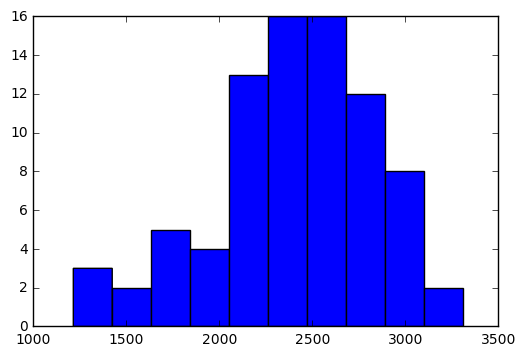

In [316]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(df_hof['G'])
plt.show()

In [317]:
print(df.columns)

Index(['playerID', 'debut', 'finalGame', 'HR', '3B', 'AB', 'RBI', 'SB', 'R',
       'HBP', 'BB', '2B', 'SF', 'G', 'Years_Played', 'H',
       'Most Valuable Player', 'AS_games', 'HoF', 'Rookie of the Year',
       'Silver Slugger', 'Gold Glove', 'bats_R', 'throws_R', 'pos2', 'pos__1B',
       'pos__2B', 'pos__3B', 'pos__C', 'pos__OF', 'pos__SS', 'debutYear',
       'finalYear', '1920-41', '1946-62', '1993-2009', '1963-76', '1977-92',
       'pre1920', '1942-45', 'YSR', 'AVE', 'OBP', 'Slug_Percent', 'OPS'],
      dtype='object')


In [318]:
num_cols_hitters = ['SB','R','BB', '2B', '3B','HR', 'RBI',
       'G', 'H', 'AB', 'AS_games','Gold Glove', 'Rookie of the Year', 
       'Silver Slugger', 'Most Valuable Player','bats_R',
       'throws_R','pos__1B', 'pos__2B',
       'pos__3B', 'pos__C', 'pos__OF', 'pos__SS', 'YSR', 'AVE', 'HoF', 'pre1920', '1920-41', '1942-45', '1946-62', '1963-76',
       '1977-92', '1993-2009', 'Years_Played', 'OBP', 'Slug_Percent', 'OPS']
data = df_hitters[num_cols_hitters]

In [319]:
print(data.columns)

Index(['SB', 'R', 'BB', '2B', '3B', 'HR', 'RBI', 'G', 'H', 'AB', 'AS_games',
       'Gold Glove', 'Rookie of the Year', 'Silver Slugger',
       'Most Valuable Player', 'bats_R', 'throws_R', 'pos__1B', 'pos__2B',
       'pos__3B', 'pos__C', 'pos__OF', 'pos__SS', 'YSR', 'AVE', 'HoF',
       'pre1920', '1920-41', '1942-45', '1946-62', '1963-76', '1977-92',
       '1993-2009', 'Years_Played', 'OBP', 'Slug_Percent', 'OPS'],
      dtype='object')


In [320]:
print(data.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 55, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 55, 55]


In [321]:
# Eliminating rows with null values
data = data.dropna()

In [322]:
print(len(data))

7884


In [323]:
data_hof = data[data['HoF'] == 1]
print(len(data_hof))

69


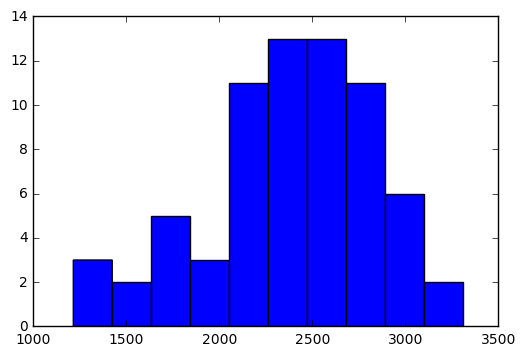

In [324]:
plt.hist(data_hof['G'])
plt.show()

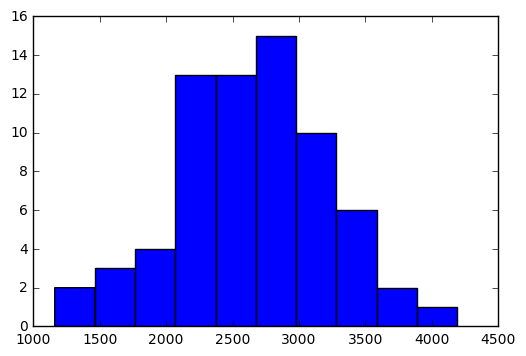

In [325]:
plt.hist(data_hof['H'])
plt.show()

In [326]:
print(data_hof[data_hof['H'] < 1500])

        SB    R    BB   2B  3B   HR     RBI     G     H    AB    ...     \
2486  25.0  627   533  178  18  242   856.0  1215  1161  4205    ...      
9123  22.0  971  1011  216  39  369  1015.0  1472  1451  5205    ...      

      1920-41  1942-45  1946-62  1963-76  1977-92  1993-2009  Years_Played  \
2486      0.0      0.0      1.0      0.0      0.0        0.0            10   
9123      0.0      0.0      1.0      0.0      0.0        0.0            10   

           OBP  Slug_Percent       OPS  
2486  0.357535      0.499643  0.861220  
9123  0.396075      0.547935  0.946332  

[2 rows x 37 columns]


In [327]:
print(data_hof['RBI'].min())

734.0


In [328]:
print(df.loc[3188])

playerID                          cochrmi01
debut                   1925-04-14 00:00:00
finalGame               1937-05-25 00:00:00
HR                                      119
3B                                       64
AB                                     5169
RBI                                     832
SB                                       64
R                                      1041
HBP                                      29
BB                                      857
2B                                      333
SF                                        0
G                                      1482
Years_Played                             13
H                                      1652
Most Valuable Player                      2
AS_games                                  2
HoF                                       1
Rookie of the Year                        0
Silver Slugger                            0
Gold Glove                                0
bats_R                          

In [329]:
print(data_hof[data_hof['G'] < 1500])

          SB     R    BB   2B  3B   HR     RBI     G     H    AB    ...     \
2486    25.0   627   533  178  18  242   856.0  1215  1161  4205    ...      
3188    64.0  1041   857  333  64  119   832.0  1482  1652  5169    ...      
6624    58.0  1051   852  379  71  331  1276.0  1394  1628  5193    ...      
9123    22.0   971  1011  216  39  369  1015.0  1472  1451  5205    ...      
14627  197.0   947   740  273  54  137   734.0  1382  1518  4877    ...      

       1920-41  1942-45  1946-62  1963-76  1977-92  1993-2009  Years_Played  \
2486       0.0      0.0      1.0      0.0      0.0        0.0            10   
3188       1.0      0.0      0.0      0.0      0.0        0.0            13   
6624       1.0      1.0      1.0      0.0      0.0        0.0            13   
9123       0.0      0.0      1.0      0.0      0.0        0.0            10   
14627      0.0      0.0      1.0      0.0      0.0        0.0            10   

            OBP  Slug_Percent       OPS  
2486   0.35753

In [330]:
print(data_hof.columns)

Index(['SB', 'R', 'BB', '2B', '3B', 'HR', 'RBI', 'G', 'H', 'AB', 'AS_games',
       'Gold Glove', 'Rookie of the Year', 'Silver Slugger',
       'Most Valuable Player', 'bats_R', 'throws_R', 'pos__1B', 'pos__2B',
       'pos__3B', 'pos__C', 'pos__OF', 'pos__SS', 'YSR', 'AVE', 'HoF',
       'pre1920', '1920-41', '1942-45', '1946-62', '1963-76', '1977-92',
       '1993-2009', 'Years_Played', 'OBP', 'Slug_Percent', 'OPS'],
      dtype='object')


In [331]:
print(data_hof['H'].min())

1161


In [332]:
target = data['HoF']
features = data.drop('HoF', axis=1)

In [333]:
print(len(data))

7884


## Don't forget to deal with class imbalance.

In [334]:
from sklearn.cross_validation import cross_val_predict, KFold
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced')
kf = KFold(features.shape[0], random_state=1)

predictions_lr = cross_val_predict(lr, features, target, cv=kf)
predictions_lr = pd.Series(predictions_lr)

In [335]:
np_predictions_lr = predictions_lr.as_matrix()
np_target = data['HoF'].as_matrix()

In [336]:
tn_filter_lr = (np_predictions_lr == 0) & (np_target == 0)
tn_lr = len(np_predictions_lr[tn_filter_lr])

tp_filter_lr = (np_predictions_lr == 1) & (np_target == 1)
tp_lr = len(np_predictions_lr[tp_filter_lr])

fn_filter_lr = (np_predictions_lr == 0) & (np_target == 1)
fn_lr = len(np_predictions_lr[fn_filter_lr])

fp_filter_lr = (np_predictions_lr == 1) & (np_target == 0)
fp_lr = len(np_predictions_lr[fp_filter_lr])

In [345]:
print(tn_lr)
print(tp_lr)
print(fn_lr)
print(fp_lr)
tnr_lr = tn_lr / (tn_lr + fp_lr)
tpr_lr = tp_lr / (tp_lr + fn_lr)
fnr_lr = fn_lr / (fn_lr + tp_lr)
fpr_lr = fp_lr / (fp_lr + tn_lr)


print(tpr_lr)
print(fpr_lr)

print(tnr_lr)
print(fnr_lr)

7730
59
10
85
0.855072463768116
0.010876519513755598
0.9891234804862444
0.14492753623188406


In [346]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1, class_weight='balanced')
predictions_rf = cross_val_predict(rf, features, target, cv=kf)
predictions_rf = pd.Series(predictions_rf)

In [347]:
print(len(predictions_rf))
print(len(data['HoF']))

7884
7884


In [348]:
np_predictions_rf = predictions_rf.as_matrix()

In [349]:
tn_filter_rf = (np_predictions_rf == 0) & (np_target == 0)
tn_rf = len(np_predictions_rf[tn_filter_rf])

tp_filter_rf = (np_predictions_rf == 1) & (np_target == 1)
tp_rf = len(np_predictions_rf[tp_filter_rf])

fn_filter_rf = (np_predictions_rf == 0) & (np_target == 1)
fn_rf = len(np_predictions_rf[fn_filter_rf])

fp_filter_rf = (np_predictions_rf == 1) & (np_target == 0)
fp_rf = len(np_predictions_rf[fp_filter_rf])

In [350]:
print(tn_rf)
print(tp_rf)
print(fn_rf)
print(fp_rf)

7806
31
38
9


In [351]:
tnr_rf = tn_rf / (tn_rf + fp_rf)
tpr_rf = tp_rf / (tp_rf + fn_rf)
fnr_rf = fn_rf / (fn_rf + tp_rf)
fpr_rf = fp_rf / (fp_rf + tn_rf)

In [352]:
print(tpr_rf)
print(fpr_rf)

print(tnr_rf)
print(fnr_rf)

0.4492753623188406
0.0011516314779270633
0.9988483685220729
0.5507246376811594
